<br>

## 데이터 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
train_origin = pd.read_csv('train.csv', index_col=0)
train = pd.read_csv('train_x_0.2_99.8.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)

# Train 데이터의 타입을 Sample_submission에 대응하는 가변수 형태로 변환
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train_origin['type_num'] = train_origin['type'].apply(lambda x : to_number(x, column_number))

# 모델에 적용할 데이터 셋 준비 
x = train
y = train_origin['type_num']

x = x.drop(columns=['fiberID'], axis=1)
test_x = test.drop(columns=['fiberID'],axis=1)

col_name = x.columns

x = np.array(x)
x = x.astype('float32')

y = np.array(y)

test_x = np.array(test_x)
test_x = test_x.astype('float32')

from sklearn.model_selection import train_test_split, KFold
x_train, x_test, y_train, y_test = train_test_split(x,y, 
                                                    train_size=0.7, 
                                                    shuffle=True ,
                                                    random_state=0)

from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()

scaler2.fit(x_train)
x_train = scaler2.transform(x_train)
x_test = scaler2.transform(x_test)

test_x = scaler2.transform(test_x)

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

C:\Users\student\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
Using TensorFlow backend.


<br>

## 데이터 모델링

In [2]:
# 모델링
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2
from keras.initializers import he_normal
from keras.optimizers import adam

num_classes = 19

model=Sequential()

model.add(Dense(64,input_shape=(20, ))) # input dimension
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))
# model.add(Dense(128, kernel_initializer=, kernel_regularizer=l2(0.01), bias_regularizer= l2(0.01), bias_initializer=))
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dropout(0.1))

model.add(Dense(256))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1344      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

<br>

## Cyclical Learning Rate Scheduling

In [3]:
# CyclicLR의 케라스 ver
from keras.callbacks import Callback
from keras import backend as K

class CyclicLR(Callback):
    def __init__(
            self,base_lr=0.001,
            max_lr=0.006,step_size=2000.,
            mode='triangular',gamma=1.,
            scale_fn=None,scale_mode='cycle'):
        
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2','exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()
    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [4]:
# import CyclicLR

STEP_SIZE = 8
BATCH_SIZE = 64

clr = CyclicLR(base_lr=0.0001, 
               max_lr=0.01, 
               step_size= STEP_SIZE, #* (x_train.shape[0] // BATCH_SIZE 
               mode='exp_range')

In [5]:
x_train.shape[0] // BATCH_SIZE

2187

In [6]:
# 모델 훈련
optimizer_adam = adam(lr=0.01, clipvalue=1.0, decay=1e-4)
model.compile(loss='categorical_crossentropy', optimizer= optimizer_adam, metrics=['accuracy'])

hist = model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=2, callbacks=[clr], validation_split=0.25)
loss, acc = model.evaluate(x_test,y_test,batch_size=64)
print('Loss:',loss,'Accuracy:',acc)

Train on 104994 samples, validate on 34999 samples
Epoch 1/50
 - 8s - loss: 0.8088 - accuracy: 0.7453 - val_loss: 0.7207 - val_accuracy: 0.7709
Epoch 2/50
 - 8s - loss: 0.6647 - accuracy: 0.7903 - val_loss: 0.6078 - val_accuracy: 0.8075
Epoch 3/50
 - 8s - loss: 0.6201 - accuracy: 0.8009 - val_loss: 0.5209 - val_accuracy: 0.8224
Epoch 4/50
 - 8s - loss: 0.5887 - accuracy: 0.8107 - val_loss: 0.4837 - val_accuracy: 0.8334
Epoch 5/50
 - 8s - loss: 0.5621 - accuracy: 0.8166 - val_loss: 0.4787 - val_accuracy: 0.8405
Epoch 6/50
 - 8s - loss: 0.5431 - accuracy: 0.8220 - val_loss: 0.4595 - val_accuracy: 0.8466
Epoch 7/50
 - 8s - loss: 0.5294 - accuracy: 0.8272 - val_loss: 0.4717 - val_accuracy: 0.8409
Epoch 8/50
 - 8s - loss: 0.5174 - accuracy: 0.8293 - val_loss: 0.4535 - val_accuracy: 0.8475
Epoch 9/50
 - 8s - loss: 0.5082 - accuracy: 0.8329 - val_loss: 0.4497 - val_accuracy: 0.8496
Epoch 10/50
 - 8s - loss: 0.5025 - accuracy: 0.8346 - val_loss: 0.4415 - val_accuracy: 0.8505
Epoch 11/50
 - 8s 

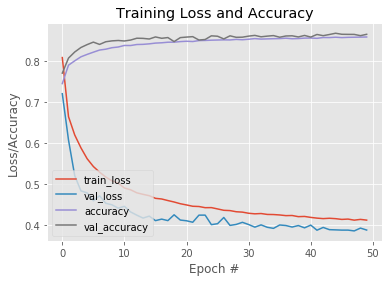

In [7]:
# 학습결과 시각화 

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

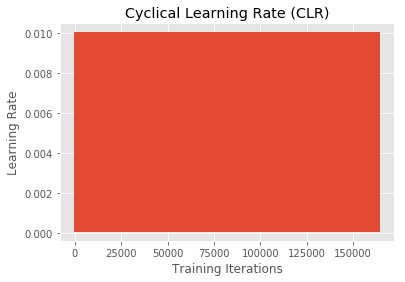

In [8]:
# plot the learning rate history
plt.figure()
plt.plot(clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.show()

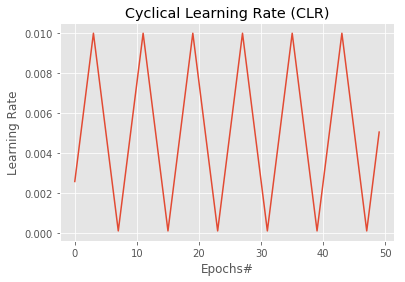

In [9]:
# plot the learning rate history
plt.figure()
plt.plot(hist.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Epochs#")
plt.ylabel("Learning Rate")
plt.show()